In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> aaa_input_FinerGrid_0027
1 -> aaa_input_FinerGrid_0031
2 -> bbb_finerfinergrid_exploding
3 -> bbb_finergrid_3d_withoutpotential
4 -> distort_input_FinerGrid_0000
5 -> distort_input_FinerGrid_0001
6 -> distort_input_FinerGrid_0002
7 -> distort_input_FinerGrid_0003
8 -> distort_input_FinerGrid_0004
9 -> distort_input_FinerGrid_0005



In [3]:
a = subfolders[-1]
#a = subfolders[1]

In [4]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
gams,thes = dictio['gams'],dictio['thes']
lastV = len(filesList)-1

# 1d slices

In [5]:
gamL = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape

In [6]:
def sliceGammas(h5File):
    wf  = qp.retrieve_hdf5_data(h5File,'WF')
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    ys = wf
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    plt.title('Time = {:10.5f} fs'.format(time))
    plt.ylim(-0.7,0.7)
    plt.plot(gams, np.real(ys), linewidth=1,ls='--')
    plt.plot(gams, np.imag(ys), linewidth=1,ls='--')
    plt.plot(gams, abs2(ys), linewidth=3,ls='-')

def fgam(file_number):
    return sliceGammas(os.path.join(a, filesList[file_number]))


interactive(children=(IntSlider(value=9, description='file_number', max=9), Output()), _dom_classes=('widget-i…

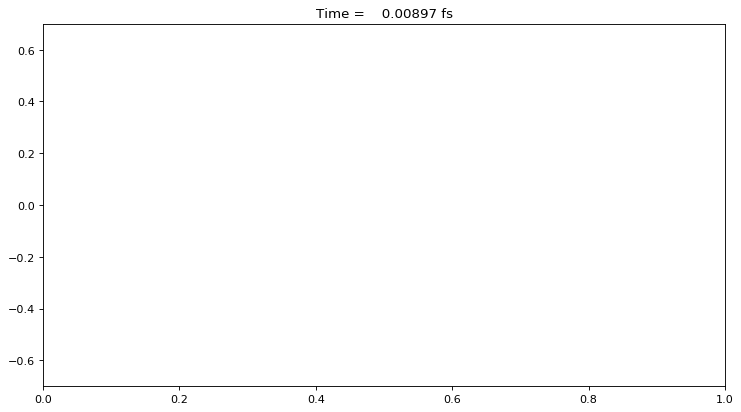

In [7]:
interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));

In [8]:
pd.DataFrame(qp.fromHartoEv(dictio['potCube'])).plot(x=gams,figsize=(11, 6));

ValueError: Length mismatch: Expected axis has 29 elements, new values have 21 elements

In [9]:
def kinGam(xder):
    pd.DataFrame(dictio['kinCube'][:,4,xder]).plot(x=gams,figsize=(11, 6))
    
interact(kinGam, xder = widgets.IntSlider(min=0,max=2,step=1,value=0));

interactive(children=(IntSlider(value=0, description='xder', max=2), Output()), _dom_classes=('widget-interact…

In [10]:
outfn = os.path.join(a,'output')

In [11]:
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
data.columns = ['steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation']
data

ValueError: Length mismatch: Expected axis has 10 elements, new values have 7 elements

In [12]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));

KeyError: 'fs'

In [13]:
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));

KeyError: 'fs'

In [14]:
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));

KeyError: 'fs'

In [15]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

KeyError: 'Kinetic'

### Expected values

In [16]:
def expected(h5file):
    wfa  = qp.retrieve_hdf5_data(h5file,'WF')
    norm = np.linalg.norm(wfa)
    wf = wfa / norm
    gamAvg = np.vdot(abs2(wf),gams)
    print('Norm: {}\n\nExpected Values:\nGamma: {:10.5f}'.format(norm,np.rad2deg(gamAvg)))

def fexp(x):
    return expected(os.path.join(a,filesList[x]))

In [17]:
interact(fexp, x = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));

interactive(children=(IntSlider(value=9, description='x', max=9), Output()), _dom_classes=('widget-interact',)…